### Problem 3: Building a Complicated Model (1 point)
I chose to follow along: https://www.tensorflow.org/tutorials/estimators/linear
***
**<font color = red>ALL CODES are referenced by </font>**https://www.tensorflow.org/tutorials/estimators/linear

In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import numpy as np
#import matplotlib.pyplot as plt
import tempfile
from tensorflow.examples.tutorials.mnist import input_data
import warnings
warnings.filterwarnings("ignore")
import tensorflow_probability as tfp
#importing the module
import tensorflow.feature_column as fc 
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import tensorflow as tf
warnings.filterwarnings("ignore")

Loading the data sets

In [2]:
#!pip install -q tf-nightly  # Requires tf 1.13
tf.enable_eager_execution()

tf.logging.set_verbosity(tf.logging.ERROR)
tf.set_random_seed(123)

# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tfbt/titanic_eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

<a href="http://tinypic.com?ref=2m7yfi8" target="_blank"><img src="http://i63.tinypic.com/2m7yfi8.png" border="0" alt="Image and video hosting by TinyPic"></a>

#### Explore the data
Let's first preview some of the data and create summary statistics on the training set.

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

There are 627 and 264 examples in the training and evaluation sets, respectively.

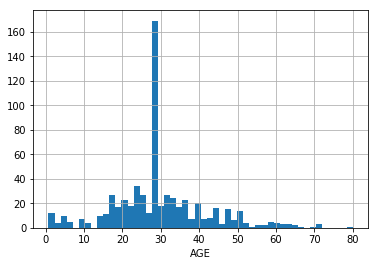

In [6]:
dftrain.age.hist(bins=50)
plt.xlabel("AGE")
_ = plt.show()

There are approximately twice as male passengers as female passengers aboard.

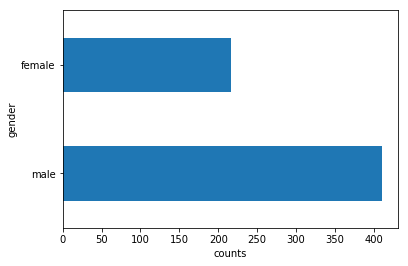

In [7]:
dftrain.sex.value_counts().plot(kind='barh')
plt.xlabel("counts")
plt.ylabel("gender")
_ = plt.show()

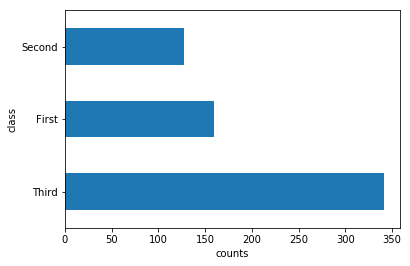

In [8]:
dftrain['class'].value_counts().plot(kind='barh')
plt.xlabel("counts")
plt.ylabel("class")
_ = plt.show()

#### Create feature columns and input functions
The Gradient Boosting estimator can utilize both numeric and categorical features. Feature columns work with all TensorFlow estimators and their purpose is to define the features used for modeling. Additionally they provide some feature engineering capabilities like one-hot-encoding, normalization, and bucketization. In this tutorial, the fields in CATEGORICAL_COLUMNS are transformed from categorical columns to one-hot-encoded columns

In [9]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
  
def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    # Need to one-hot encode categorical features.
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
#  
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

below are the features in training set

In [10]:
print("features are %s "%[i[0][0] for i in feature_columns])

features are ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone', 'a', 'f'] 


In [11]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle thru dataset as many times as need (n_epochs=None).    
        dataset = (dataset.repeat(n_epochs).batch(NUM_EXAMPLES)) 
        return dataset
    return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [12]:
train_input_fn

<function __main__.make_input_fn.<locals>.input_fn()>

#### Train and evaluate the model
Below you will do the following steps:

Initialize the model, specifying the features and hyperparameters.
Feed the training data to the model using the train_input_fn and train the model using the train function.
You will assess model performance using the evaluation set—in this example, the dfeval DataFrame. You will verify that the predictions match the labels from the y_eval array.

Before training a Boosted Trees model, let's first train a linear classifier (logistic regression model). It is best practice to start with simpler model to establish a benchmark.

In [13]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.78409094
Dummy model:  0.625


Next let's train a Boosted Trees model. For boosted trees, regression (BoostedTreesRegressor) and classification (BoostedTreesClassifier) are supported, along with using any twice differentiable custom loss (BoostedTreesEstimator). Since the goal is to predict a class - survive or not survive, you will use the BoostedTreesClassifier.

In [14]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
results = est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy :  0.8181818
Dummy model:  0.625


For performance reasons, when your data fits in memory, it is recommended to use the boosted_trees_classifier_train_in_memory function. However if training time is not of a concern or if you have a very large dataset and want to do distributed training, use the tf.estimator.BoostedTrees API shown above.

When using this method, you should not batch your input data, as the method operates on the entire dataset.

Now you can use the train model to make predictions on a passenger from the evaluation set. TensorFlow models are optimized to make predictions on a batch, or collection, of examples at once. Earlier, the eval_input_fn is defined using the entire evaluation set.

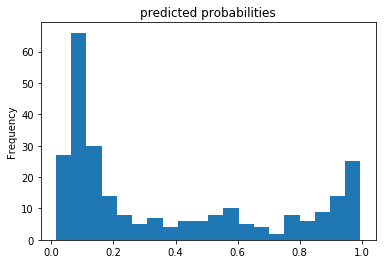

In [16]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')
_ = plt.show()

Finally you can also look at the receiver operating characteristic (ROC) of the results, which will give us a better idea of the tradeoff between the true positive rate and false positive rate.



(0, 1.05)

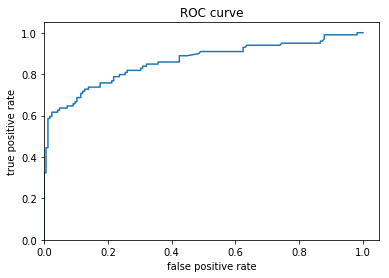

In [17]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)